# Tracking Dataset Processing

This notebook can be used to load, evaluate, compare, refine and export hand-labeled tracking datasets 

*(Data must be annotated with the blender [**OmniTrax**](https://github.com/FabianPlum/OmniTrax) addon or [**blenderMotionExport**](https://github.com/FabianPlum/blenderMotionExport) or follow the convention of individual CSV files per tracked animal with explicit frame numbers)*

First, let's load some packages and a few essential import / export functions from **Antrax_base.py** 

In [1]:
import numpy as np
import cv2
import csv
import os
import math
import time
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# now for the file management fucntions
from Antrax_base import import_tracks, display_video, get_exact_frame, extractPatches, display_patches, sortByDistance

To get more information on how each function works, you can simply type it out followed by a question mark to display its docstring below:

In [7]:
# Exp: Show the docstring of "import_tracks" by uncommenting the next line
import_tracks?

Now specify the **location** of all **export folders** of tracks you wish to analyse. Simply add the folder path to the **export_paths** array and the location of the annotated video file.

In [3]:
export_paths = ["C:/export/rose_petals_right"]
video = "I:/FELIX_dark_market/Data/ebay_data_new/rose_petals_right.avi"

# enter the number of annotated frames:
tracked_frames = 1000

# now we can load the captured video file and display it
cap = cv2.VideoCapture(video)

# check the number of frames of the imported video file
numFramesMax = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("The imported clip:", video, "has a total of",numFramesMax ,"frames.\n")

# now let's load all tracks listed in the export_paths
tracks = []
for folder in export_paths:
    # You can export all tracks into a single .csv file by setting "export=True"
    tracks.append(import_tracks(folder, numFramesMax, export=True))
    
    # The following function is used to display the tracks you imported.
    # You can press "q" while hovering over the displayed video to exit.
    print("\nDisplaying tracks loaded from:", folder)
    display_video(cap, tracks[-1], show=(0, tracked_frames), scale=0.3)

The imported clip: I:/FELIX_dark_market/Data/ebay_data_new/rose_petals_right.avi has a total of 97490 frames.

importing tracks...
imported rose_petals_right_track_0.csv  with 413 points.
imported rose_petals_right_track_1.csv  with 386 points.
imported rose_petals_right_track_2.csv  with 900 points.
imported rose_petals_right_track_20.csv  with 199 points.
imported rose_petals_right_track_29.csv  with 18 points.
imported rose_petals_right_track_3.csv  with 196 points.
imported rose_petals_right_track_33.csv  with 18 points.
imported rose_petals_right_track_4.csv  with 128 points.
imported rose_petals_right_track_5.csv  with 834 points.
imported rose_petals_right_track_6.csv  with 663 points.
imported rose_petals_right_track_7.csv  with 131 points.

Successfully combined the tracks of 11 individuals for training and display!

Displaying tracks loaded from: C:/export/rose_petals_right

Displaying tracked footage!
press 'q' to end display

Reached last frame of specified video or ended b

Next, we'll plot the imported trajectories from each subfolder.

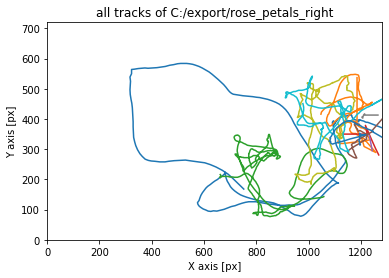

In [4]:
# get the resolution of the video file to automatically adjust the axis limits of the plot
resolution = [int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))]

def plot_tracks(tracks, title=""):
    # replace all zeros with None before plotting
    tracks = tracks.astype(float)
    tracks[tracks == 0] = None

    for track in range(int((tracks.shape[-1] - 1) / 2)):
        plt.plot(tracks[:tracked_frames,int(track*2 + 1)],tracks[:tracked_frames,int(track*2 + 2)])

        plt.title(title)    
        plt.xlabel("X axis [px]")   
        plt.ylabel("Y axis [px]")
        plt.xlim(0,resolution[0])
        plt.ylim(0,resolution[1])

    plt.show()
    
# plot all tracks    
for count, annotator in enumerate(tracks):
    num_tracks = int((annotator.shape[-1] - 1)/2)  
    plot_tracks(tracks=annotator,title="all tracks of " + export_paths[count])

Now we'll match the **tracks** of **all annotators** based on their **proximity**. We'll iterate through all tracks of the first annotator and compute a similirity score based on the distance of each tracked instance, ignoring zeros.

In [5]:
def get_similarity(track_1, track_2, matching_threshold=50):
    # here we use the pixel distance as a metric of similarity
    # the lower the pixel distance, thus similarity value, the higher the liklihood of two track belonging to the same ID
    combined_distance = []
    track_1 = track_1.astype(float)
    track_2 = track_2.astype(float)
    for frame, coords in enumerate(track_1):
        if not np.array_equal(track_1[frame],[0,0]) and not np.array_equal(track_2[frame],[0,0]):
            combined_distance.append(np.sqrt(np.power(track_1[frame,0] - track_2[frame,0],2) +
                                             np.power(track_1[frame,1] - track_2[frame,1],2)))
            
    # now compute the similarity as the mean distance between the two tracks
    if combined_distance:
        similarity = np.round(np.mean(combined_distance), decimals=3)
    else:
        similarity = matching_threshold
    return similarity


def match_tracks(tracks_a, tracks_b):
    num_tracks_a = int((tracks_a.shape[1] - 1)/2)
    num_tracks_b = int((tracks_b.shape[1] - 1)/2)
    similarities = np.empty([num_tracks_a, num_tracks_b], dtype=float)
    print("Similarity grid shape:", similarities.shape, "\n")
    print("Computing similarities...")

    # compare all tracks of 2 annotators at a time and match them based on their mean euclidean distance
    for a in range(similarities.shape[0]):
        for b in range (similarities.shape[1]):
            similarities[a,b] = get_similarity(track_1=tracks_a[:tracked_frames,a*2 + 1:a*2 + 3],
                                               track_2=tracks_b[:tracked_frames,b*2 + 1:b*2 + 3],
                                               matching_threshold = matching_threshold)

    # record the indices of all likely matches and unmatched tracks
    matched = []
    unmatched_a = []
    unmatched_b = np.arange(num_tracks_b)

    for track_a, track_a_similarities in enumerate(similarities):
        sim_max = np.argmin(track_a_similarities[np.nonzero(track_a_similarities)])
        if track_a_similarities[sim_max] < matching_threshold:
            matched.append([track_a,sim_max])
            unmatched_b[sim_max] = 0
            print("Track", track_a, "most likely corresponds to Track", sim_max,
                  "with a mean euclidean distance [px] of", track_a_similarities[sim_max])
        else:
            unmatched_a.append(track_a)
            print("Track", track_a, "has no likely match.")

    # show list of matched tracks        
    print("\nmatched:\n",matched,"\n")

    if len(unmatched_a) > 0:
        print("Unmatched tracks of",export_paths[0],": \n",unmatched_a,"\n")
    else:
        print("All tracks of",export_paths[0], "have been matched!\n")

    # create the final list of unmatched_b tracks
    unmatched_b = unmatched_b[unmatched_b != 0]
    if len(unmatched_b) > 0:
        print("Unmatched tracks of",export_paths[1],": \n",unmatched_b,"\n")
    else:
        print("All tracks of",export_paths[1], "have been matched!\n")

    return matched, unmatched_a, unmatched_b


def generate_ground_truth(tracks_a, tracks_b, matches, unmatched_a, unmatched_b, num_frames, 
                          iteration=0, ignore_unmatched=False):
    # create array of the size of (num_frames x (frame + all_tracks(x,y)))
    ground_truth = np.zeros([num_frames, 1 + 2 * (len(matches) + len(unmatched_a) + len(unmatched_b))])
    
    # add frame numers to the first column
    frames = np.arange(1,num_frames + 1)
    
    ground_truth[:,0] = frames
    
    if iteration == 0:
        print("Initial combination of tracks. All are weighted equally")
    else: 
        print("Iteration:", iteration)
        print("Additional tracks contribute with 1/"+ str(iteration + 2),"weight.\n")
    
    # now compute the weighted average for every matching track
    for count, match in enumerate(matches):
        for frame in range(ground_truth.shape[0]):
            pos_a_x, pos_a_y = tracks_a[frame , 2 * match[0] + 1 : 2 * match[0] + 3]
            pos_b_x, pos_b_y = tracks_b[frame , 2 * match[1] + 1 : 2 * match[1] + 3]
            
            pos_sum_x = pos_a_x * (1 + iteration) + pos_b_x
            pos_sum_y = pos_a_y * (1 + iteration) + pos_b_y
            
            if pos_a_x != 0 and pos_b_x != 0:
                ground_truth[frame,count * 2 + 1] = pos_sum_x / (2 + iteration)
            else:
                # only compute the average if both values are non-zero
                # If one value is zero, only the other should contribute to the track
                ground_truth[frame,count * 2 + 1] = pos_sum_x
                
            # repeat for the y-axis
            
            if pos_a_y != 0 and pos_b_y != 0:
                ground_truth[frame,count * 2 + 2] = pos_sum_y / (2 + iteration)
            else:
                # only compute the average if both values are non-zero
                # If one value is zero, only the other should contribute to the track
                ground_truth[frame,count * 2 + 2] = pos_sum_y
                
    # add the remaining unmatched_a tracks
    if len(unmatched_a) > 0:
        for count, unmatched in enumerate(unmatched_a):
            ground_truth[:,(count + len(matches)) * 2 + 1: (count + len(matches)) * 2 + 3] = tracks_a[
                :tracked_frames,unmatched * 2 + 1 : unmatched * 2 + 3]
    
    # add the remaining unmatched_b tracks
    if len(unmatched_b) > 0:
        for count, unmatched in enumerate(unmatched_b):
            ground_truth[:,(count + len(unmatched_a) + len(matches)) * 2 + 1: 
                         (count + len(unmatched_a) + len(matches)) * 2 + 3] = tracks_b[
                :tracked_frames,unmatched * 2 + 1 : unmatched * 2 + 3]
    
    return ground_truth

After computing **likely matching tracks** we can now combine them into **ground truth tracks**, which are a weighted average of all matching tracks. **Unmatched tracks** are added without modification. Then, we iteratively compare the current ground truth to further annotators.

In [6]:
# adjust the matching threshold according to the track quality and resolution of the tracked footage
matching_threshold = 50

# compute a grid of similarities between all tracks

matched, unmatched_a, unmatched_b = match_tracks(tracks_a = tracks[0], tracks_b = tracks[1])

IndexError: list index out of range

In [ ]:
gt = generate_ground_truth(tracks_a=tracks[0], tracks_b=tracks[1], matches=matched, unmatched_a=unmatched_a, 
                      unmatched_b=unmatched_b, num_frames=tracked_frames, iteration=0)

print("Generated a total of",int((gt.shape[-1] - 1) / 2),"ground truth tracks.")

display_video(cap, gt, show=(0, tracked_frames - 2), scale=0.3)

# plot resulting ground truth tracks
plot_tracks(tracks=gt, title="all ground truth tracks")

The generated **ground truth tracks** can now be exported.

In [ ]:
def export_tracks(tracks,path="ground_truth"):
    tracks = tracks.astype(int)
    np.savetxt(path + ".csv", tracks, delimiter=",")
    
    print("Exported tracks successfully to", path + ".csv")
    
export_tracks(tracks=gt, path="ground_truth_" + video.split(".")[0])

We can also **import** existing ground truth files for evaluation or to add further annotators. When adding additional annotators, make sure to correctly set the iteration to weigh the influence of further tracks correctly.

In [ ]:
def import_ground_truth(path):
    tracks = np.loadtxt(path, delimiter=",")
    tracks = tracks.astype(int)
    
    print("Imported tracks successfully from", path)
    
    return tracks

new_gt = import_ground_truth(path="ground_truth_rec_climate_chamber_sub_colony_base_10000_frames.csv")

In [ ]:
def get_derivative(tracks, time_step=1/30):
    tracks_der = np.zeros([tracks.shape[0],int((tracks.shape[1] - 1)/2)])
    # convert tracks to float array
    tracks_der = tracks_der.astype(float)
    
    num_tracks = int((tracks.shape[1] - 1)/2)  
    num_timeSteps = tracks.shape[0]
    
    print("Computing derivative for", num_tracks, "tracks...")
    for track in range(num_tracks):
        track_der = []
        for t in range(num_timeSteps - 1):
            if tracks[t + 1,track * 2 + 1] != 0 and tracks[t + 1,track * 2 + 2] != 0:   
                tracks_der[t,track] = np.sqrt((tracks[t + 1,track * 2 + 1] - tracks[t,track * 2 + 1])**2 + 
                                              (tracks[t + 1,track * 2 + 2] - tracks[t,track * 2 + 2])**2) / time_step
            
    return tracks_der

def apply_moving_average(tracks, samples=3, padding_mode='valid'):
    tracks_ma = np.copy(tracks)
    num_tracks = int((tracks.shape[1] - 1)/2)  
    num_timeSteps = tracks.shape[0]

    print("Applying moving average of size", samples, "to", num_tracks, "tracks...")
    for t in range(num_tracks):
        # apply smoothing only to areas where tracked subject is in view
        # therefore, all zero entries must be ignored
        track_temp_x = tracks[:,t * 2 + 1]
        track_temp_y = tracks[:,t * 2 + 2]
        
        nonzeroind = np.nonzero(track_temp_x)[0]
        
        track_x = np.convolve(track_temp_x[nonzeroind[0]:nonzeroind[-1]-samples], np.ones(samples)/samples, mode=padding_mode)
        track_y = np.convolve(track_temp_y[nonzeroind[0]:nonzeroind[-1]-samples], np.ones(samples)/samples, mode=padding_mode)
        
        tracks_ma[nonzeroind[0] + math.floor(samples/2):nonzeroind[-1] - math.ceil(samples/2) - samples + 1, t * 2 + 1] = track_x
        tracks_ma[nonzeroind[0] + math.floor(samples/2):nonzeroind[-1] - math.ceil(samples/2) - samples + 1, t * 2 + 2] = track_y    
        
    # add back zeros
    tracks_ma = tracks_ma.astype(int)
    return tracks_ma

In [ ]:
tracks_smoothed = apply_moving_average(new_gt, samples=9)
tracks_velocity = get_derivative(tracks_smoothed)

# plot smoothed ground truth tracks
plot_tracks(tracks=tracks_smoothed, title="smoothed ground truth tracks")

# plot velocity profile of example ground truth tracks
plt.plot(tracks_velocity[:,5:10])
plt.title("example velocity profiles of smoothed tracks")
plt.xlabel("time [s]")
plt.ylabel("velocity [px/s]")
plt.ylim(0,600)
plt.show()

In [ ]:
# plot heatmap of ground truth tracks
# first, combine all traccks into an array of X,Y coords
tracks_compressed = np.array([], dtype=np.int64).reshape(0,2)
for track in range(int((new_gt.shape[1] - 1)/2)):
    tracks_compressed = np.vstack((tracks_compressed,new_gt[:,track * 2 + 1 : track * 2 + 3]))
    
# now remove all zero entries from the array to prevent the 0 bin from over saturating the plot
tracks_compressed = tracks_compressed[~np.all(tracks_compressed == 0, axis=1)]
    
heatmap, xedges, yedges = np.histogram2d(tracks_compressed[:,0], tracks_compressed[:,1], 
                                         bins=(int(resolution[0]/100),int(resolution[1]/100)),
                                         range=[[0,resolution[0]],[0,resolution[1]]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

from matplotlib.image import NonUniformImage

fig, ax = plt.subplots()

im = NonUniformImage(ax, interpolation='bilinear', extent=extent)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, heatmap.T)
ax.images.append(im)

plt.xlabel("X axis [px]")   
plt.ylabel("Y axis [px]")
plt.xlim(0,resolution[0])
plt.ylim(0,resolution[1])
plt.title("heatmap of ground truth tracks")
plt.show()